In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pingouin as pg
import seaborn as sns

from glob import glob
from sklearn.metrics import cohen_kappa_score

In [2]:
qc_files = glob("ratings/expertqc*.csv")

expert_qc = dd.read_csv(qc_files, usecols=["subject", "rating"], include_path_column=True).compute()
expert_qc["rater"] = expert_qc["path"].apply(
    lambda s: op.basename(s).replace("expertqc-", "").replace(".csv", "")
).astype(str)
expert_qc.drop("path", axis="columns", inplace=True)
expert_qc.reset_index(drop=True, inplace=True)

In [3]:
print(expert_qc.shape)

(1000, 3)


In [4]:
expert_qc.head()

,subject,rating,rater
0,sub-NDARTF781TM8_ses-HBNsiteCBIC,1,wrathfulMuesli7
1,sub-NDARVC711ZK0_ses-HBNsiteCBIC,-1,wrathfulMuesli7
2,sub-NDARDX857DLB_ses-HBNsiteRU,1,wrathfulMuesli7
3,sub-NDARJH492TVW_ses-HBNsiteCBIC,1,wrathfulMuesli7
4,sub-NDARTB203DU7_ses-HBNsiteCBIC,-1,wrathfulMuesli7


In [5]:
expert_qc.groupby("subject").agg(["mean", "median", "std", "min", "max", "count"])

rating                               
                                   mean median       std min max count
subject                                                               
sub-NDARAC857HDB_ses-HBNsiteCBIC   -2.0     -2  0.000000  -2  -2     5
sub-NDARAH304ED7_ses-HBNsiteRU      0.6      1  1.140175  -1   2     5
sub-NDARAJ689BVN_ses-HBNsiteRU      1.2      1  0.836660   0   2     5
sub-NDARAP785CTE_ses-HBNsiteRU     -2.0     -2  0.000000  -2  -2     5
sub-NDARAU530GLJ_ses-HBNsiteCBIC    1.6      2  0.547723   1   2     5
...                                 ...    ...       ...  ..  ..   ...
sub-NDARZE963MEU_ses-HBNsiteCBIC    1.8      2  0.447214   1   2     5
sub-NDARZH672BAM_ses-HBNsiteRU      1.2      2  1.303840  -1   2     5
sub-NDARZR968TLL_ses-HBNsiteCUNY   -1.4     -1  0.547723  -2  -1     5
sub-NDARZV421TCZ_ses-HBNsiteCBIC   -1.4     -1  0.547723  -2  -1     5
sub-NDARZV749GAP_ses-HBNsiteCBIC    1.4      1  0.547723   1   2     5

[200 rows x 6 columns]

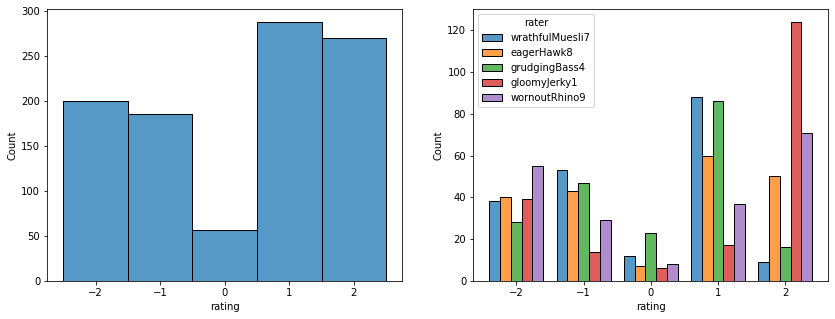

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

_ = sns.histplot(
    data=expert_qc,
    x="rating",
    bins=np.linspace(-2.5, 2.5, 6),
    ax=ax[0]
)

_ = sns.histplot(
    data=expert_qc,
    x="rating",
    bins=np.linspace(-2.5, 2.5, 6),
    hue="rater",
    multiple="dodge",
    shrink=0.8,
    ax=ax[1]
)

# Inter-rater reliability (IRR)
## Compute pairwise Cohen's alpha for each pair of raters

In [13]:
ratings = expert_qc.pivot(index="subject", columns="rater", values="rating")

cohen_kappas = {}
for rater in ratings.columns:
    cohen_kappas[rater] = [
        cohen_kappa_score(
            ratings[rater].to_numpy(),
            ratings[other_rater].to_numpy(),
            labels=[-2, -1, 0, 1, 2],
            weights="quadratic",
        ) for other_rater in ratings.columns
    ]

df_kappa = pd.DataFrame(cohen_kappas, index=ratings.columns)
for rater in ratings.columns:
    df_kappa.loc[rater, rater] = np.nan

print("pairwise kappa values:")
display(df_kappa)
print(f"\nMean kappa values for each rater:\n{df_kappa.mean()}")
print(f"\nMean kappa across all raters = {df_kappa.mean().mean()}")

pairwise kappa values:


,eagerHawk8,gloomyJerky1,grudgingBass4,wornoutRhino9,wrathfulMuesli7
rater,,,,,
eagerHawk8,NaN,0.731975,0.574662,0.645453,0.700191
gloomyJerky1,0.731975,NaN,0.571451,0.657881,0.594976
grudgingBass4,0.574662,0.571451,NaN,0.522337,0.597786
wornoutRhino9,0.645453,0.657881,0.522337,NaN,0.600308
wrathfulMuesli7,0.700191,0.594976,0.597786,0.600308,NaN



Mean kappa values for each rater:
eagerHawk8         0.663070
gloomyJerky1       0.639071
grudgingBass4      0.566559
wornoutRhino9      0.606495
wrathfulMuesli7    0.623315
dtype: float64

Mean kappa across all raters = 0.619702130705001


## Compute intra-class correlation (ICC)

We use the `pingouin` library to compute intra-class correlation and limit our output to the
"**ICC3**" case in which a fixed set of $k$ raters rate each target because our expert QC
was completed using a fully-crossed design. There is no generalization to a larger population of raters.

Furthermore, this reliability can then be estimated using different units of analysis to which
the ICC results will apply, a single rating (i.e. **ICC3**) or for the average of $k$ ratings
(i.e. **ICC3k**).
In this study, since all subjects are coded by multiple raters and the average of their ratings is
used for hypothesis testing, **ICC3k** is appropriate.
However, in studies where a subset of subjects is coded by multiple raters and the reliability of
their ratings is meant to generalize to other subjects rated by only one coder,
a single-measures ICC must be used (i.e. **ICC3**). This does not apply here but we leave the
result for reference.

See [doi:10.20982/tqmp.08.1.p023](doi:10.20982/tqmp.08.1.p023) for further information.

In [8]:
icc = pg.intraclass_corr(
    data=expert_qc,
    targets="subject",
    raters="rater",
    ratings="rating"
).round(3).set_index("Type").filter(like="ICC3", axis="index")
icc

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC3,Single fixed raters,0.662,10.811,199,796,0.0,"[0.61, 0.72]"
ICC3k,Average fixed raters,0.908,10.811,199,796,0.0,"[0.89, 0.93]"


The columns of the above dataframe are:

- `Description`: description of the ICC
- `ICC`: intraclass correlation
- `F`: F statistic
- `df1`: numerator degree of freedom
- `df2`: denominator degree of freedom
- `pval`: p-value
- `CI95%`: 95% confidence intervals around the ICC

Looking at the **ICCk** result, we see that our IRR is excellent. Also note that the **ICC** result is consistent with the average pairwise kappa. Norman and Streiner (2008) show that using a weighted kappa with quadratic weights for ordinal scales is identical to a two-way mixed, single-measures, consistency ICC, and the two may be substituted interchangeably.